In [1]:
datasetName = 'brain_MTG_AllenBrainAtlas'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/brain_MTG_AllenBrainAtlas")

In [17]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), sep = "\t", row.names = 5, h = T)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [18]:
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,cell_ID,F1S4_160106_001_B01,F1S4_160106_001_C01,F1S4_160106_001_E01,F1S4_160106_001_G01
,<chr>,<int>,<int>,<int>,<int>
1,3.8-1.2,0,0,0,0
2,3.8-1.3,0,0,0,0
3,3.8-1.4,0,0,0,0
4,3.8-1.5,0,0,0,0
5,5-HT3C2,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
F1S4_160106_001_B01,brain,MTG,L5,normal,H200.1030,M,19710
F1S4_160106_001_C01,brain,MTG,L5,normal,H200.1030,M,19710
F1S4_160106_001_E01,brain,MTG,L5,normal,H200.1030,M,19710
F1S4_160106_001_G01,brain,MTG,L5,normal,H200.1030,M,19710
F1S4_160106_001_H01,brain,MTG,L5,normal,H200.1030,M,19710


[1] Inh L4-6 SST B3GAT2     Exc L5-6 RORB TTC12     Exc L5-6 FEZF2 ABO     
[4] Exc L5-6 FEZF2 EFTUD1P1 Exc L3-5 RORB ESR1     
76 Levels: Astro L1-2 FGFR3 GFAP Astro L1-6 FGFR3 SLC14A1 ... OPC L1-6 PDGFRA

In [19]:
row.names(data.matrix) <- data.matrix[,1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]

,F1S4_160106_001_B01,F1S4_160106_001_C01,F1S4_160106_001_E01,F1S4_160106_001_G01,F1S4_160106_001_H01
,<int>,<int>,<int>,<int>,<int>
3.8-1.2,0,0,0,0,0
3.8-1.3,0,0,0,0,0
3.8-1.4,0,0,0,0,0
3.8-1.5,0,0,0,0,0
5-HT3C2,0,0,0,0,0


In [20]:
# Pre-processing
min.cells = 3
min.features = 2000
percent.mt.thre = 5
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

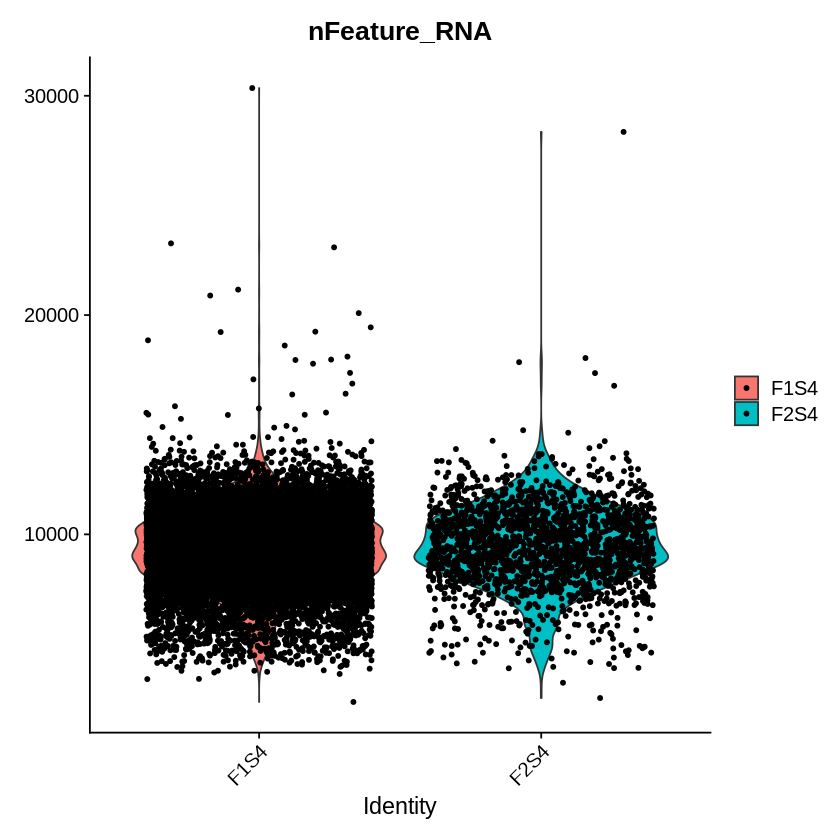

In [6]:
VlnPlot(dataobj, features = 'nFeature_RNA')

In [21]:
# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
nFeature_RNA_range = c(2000, 15000)
# dataobj <- subset(dataobj, subset = nFeature_RNA > 200)
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


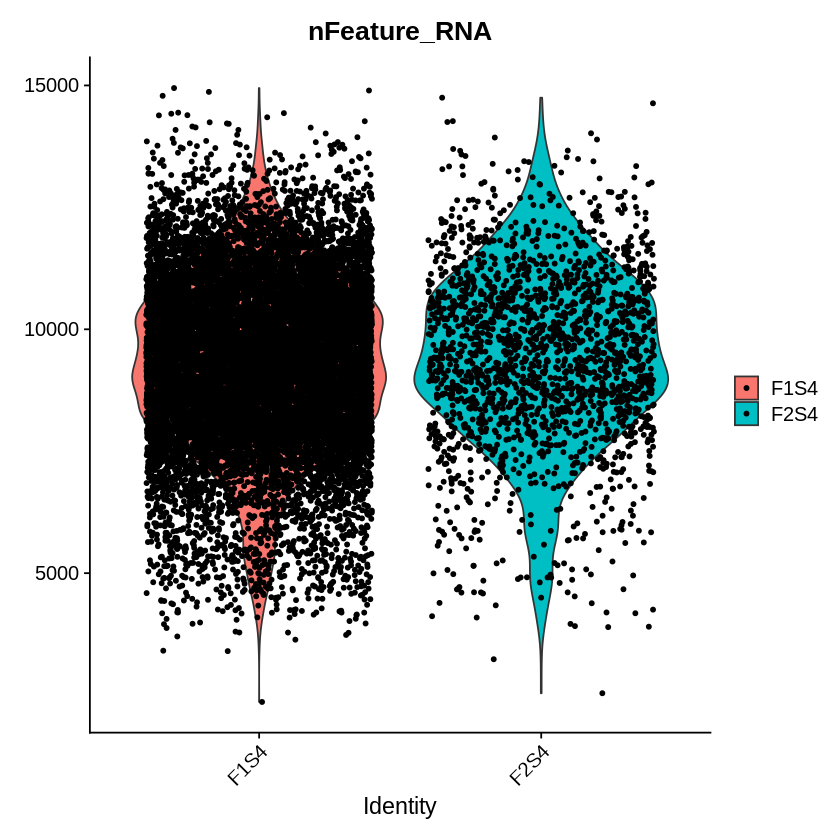

In [8]:
VlnPlot(dataobj, features = 'nFeature_RNA')

In [22]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst') # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [23]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  PTGDS, NCKAP5, DOCK5, SLC1A3, DOCK1, PON2, RFTN2, COL4A5, GLUL, PLP1 
	   ST18, NDRG2, RNF220, ZBTB20, KANK1, TMEM63A, QKI, CERCAM, GPRC5B, TMEM144 
	   S100B, DAAM2, MOG, C10orf90, TTYH2, UGT8, CNDP1, LOC101929249, PHLDB1, KIAA1755 
Negative:  GRIK2, NRG1, ROBO2, DPP10, CDH9, CNTN5, LOC105378334, LOC105371832, HS3ST4, TRHDE 
	   FAM19A1, PTPRT, FOXP2, CBLN2, LINC01378, IL1RAPL2, CCK, LOC101927587, LOC105370610, ZNF804B 
	   TSHZ2, GALNTL6, DCC, LOC105374971, PCDH11X, UNC13C, LOC401134, LOC105375931, LOC105377390, LOC105374524 
PC_ 2 
Positive:  PLP1, ST18, MOG, CERCAM, CNDP1, MOBP, LOC101927459, CARNS1, ENPP2, LOC101929249 
	   MBP, OPALIN, RNASE1, CLDN11, UGT8, ABCA8, FOLH1, MYRF, SLC5A11, SLCO1A2 
	   LOC101927967, FA2H, MAG, PPP1R14A, SCD, CTNNA3, SPP1, ERMN, SLC44A1, SH3TC2 
Negative:  RNF219-AS1, FGFR3, SLCO1C1, LINC00499, ATP1A2, NHSL1, RANBP3L, GLI3, PRODH, SLC1A2 
	   ETNPPL, HIF3A, STON2, PRDM16, COL5A3, SLC25A18, SLC7A11, ATP13A4, LOC101927437, PITPNC1 
	  

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


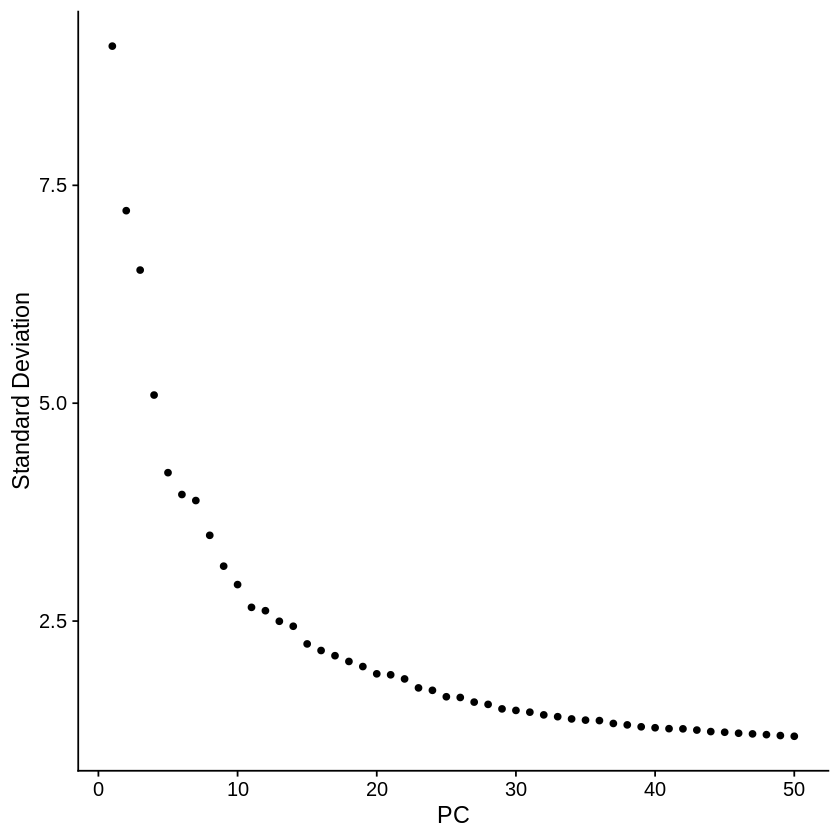

In [24]:
ElbowPlot(dataobj, ndims = 100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [25]:
dev.off()
pcDim = 20 # set as 75 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

01:23:47 UMAP embedding parameters a = 0.9922 b = 1.112

01:23:47 Read 15895 rows and found 20 numeric columns

01:23:47 Using Annoy for neighbor search, n_neighbors = 30

01:23:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

01:23:50 Writing NN index file to temp file /tmp/RtmpnQ5Tw4/file26957769f9e

01:23:50 Searching Annoy index using 1 thread, search_k = 3000

01:23:55 Annoy recall = 100%

01:23:55 Commencing smooth kNN distance calibration using 1 thread

01:23:56 Initializing from normalized Laplacian + noise

01:23:58 Commencing optimization for 200 epochs, with 680894 positive edges

01:24:14 Optimization finished



In [26]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, k.param = 15)
dataobj <- FindClusters(dataobj, resolution = 0.5)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15895
Number of edges: 568667

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9511
Number of communities: 22
Elapsed time: 2 seconds


01:24:19 UMAP embedding parameters a = 0.9922 b = 1.112

01:24:19 Read 15895 rows and found 20 numeric columns

01:24:19 Using Annoy for neighbor search, n_neighbors = 30

01:24:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

01:24:21 Writing NN index file to temp file /tmp/RtmpnQ5Tw4/file2696343c72d

01:24:21 Searching Annoy index using 1 thread, search_k = 3000

01:24:26 Annoy recall = 100%

01:24:26 Commencing smooth kNN distance calibration using 1 thread

01:24:27 Initializing from normalized Laplacian + noise

01:24:30 Commencing optimization for 200 epochs, with 680894 positive edges

01:24:45 Optimization finished



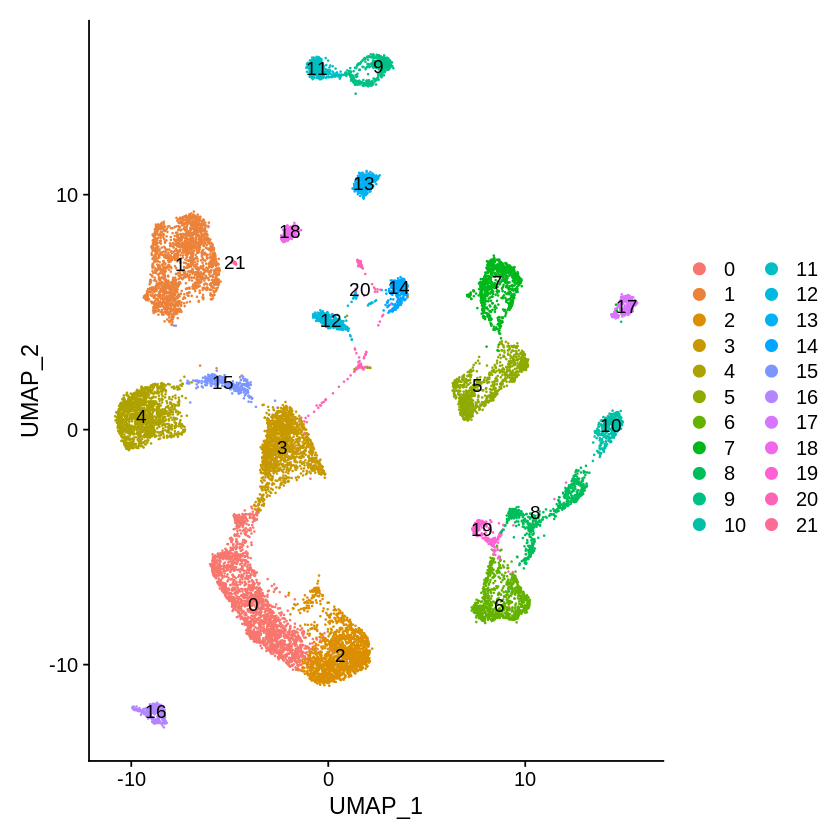

In [27]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [85]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

In [16]:
cluster <- as.character(dataobj@meta.data$cell_cluster)
for (i in 1:length(cluster)){
    cluster[i] <- strsplit(cluster[i], ' ')[[1]][1]
}
dataobj@meta.data$cell_cluster_broader <- cluster
# dataobj <- AddMetaData(dataobj, metadata = cluster)

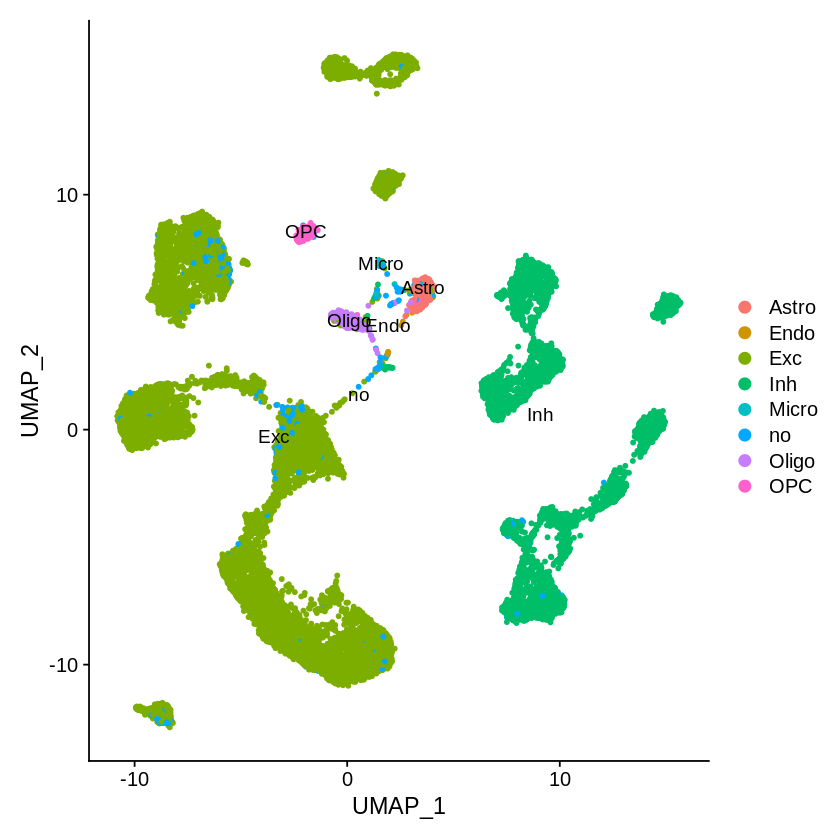

In [17]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster_broader", pt.size=1)
p_umap2

In [18]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [ ]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)


In [84]:
annotation <- as.data.frame(cbind(row.names(dataobj@meta.data), as.vector(cluster), seurat_cluster = as.character(Idents(dataobj))))
annotation <- annotation[, -1]
annotation <- annotation[order(annotation$seurat_cluster, annotation$V2), ]
print(annotation)

         V2 seurat_cluster
36      Exc              0
233     Exc              0
254     Exc              0
265     Exc              0
281     Exc              0
288     Exc              0
290     Exc              0
291     Exc              0
302     Exc              0
306     Exc              0
310     Exc              0
316     Exc              0
319     Exc              0
374     Exc              0
376     Exc              0
381     Exc              0
384     Exc              0
385     Exc              0
391     Exc              0
392     Exc              0
396     Exc              0
397     Exc              0
400     Exc              0
401     Exc              0
407     Exc              0
408     Exc              0
410     Exc              0
411     Exc              0
412     Exc              0
413     Exc              0
415     Exc              0
416     Exc              0
417     Exc              0
423     Exc              0
427     Exc              0
428     Exc              0
4

In [161]:
write.csv(annotation, file = "/stor/public/hcad/brain_LGN_AllenBrainAtlas/brain_LGN_AllenBrainAtlas.seurat.correctness.csv", quote = FALSE)

In [28]:
new.cluster.ids <- c("Brain-Nerve tissue-Excitatory neuron-CAMK2A", "Brain-Nerve tissue-Excitatory neuron-SLC17A7", "Brain-Nerve tissue-Excitatory neuron-CAMK2A", 
                     "Brain-Nerve tissue-Excitatory neuron-SLC17A7", "Brain-Nerve tissue-Excitatory neuron-SLC17A7",
                     rep("Brain-Nerve tissue-Inhibitory neuron-GAD1", 4), "Brain-Nerve tissue-Excitatory neuron-SLC17A7", 
                     "Brain-Nerve tissue-Inhibitory neuron-GAD1", "Brain-Nerve tissue-Excitatory neuron-SLC17A7", 'Brain-Nerve tissue-Oligodendrocyte-OLIG1', 
                     'Brain-Nerve tissue-Excitatory neuron-FEZF2', 'Brain-Nerve tissue-Astrocyte-AQP4', 
                     "Brain-Nerve tissue-Excitatory neuron-SLC17A7", 'Brain-Nerve tissue-Excitatory neuron-THEMIS', "Brain-Nerve tissue-Inhibitory neuron-GAD1", 
                     'Brain-Nerve tissue-Oligodendrocyte precursor cell-OLIG2', "Brain-Nerve tissue-Inhibitory neuron-GAD1", 'Brain-Nerve tissue-Microglia-CX3CR1', 
                     'Unknown')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

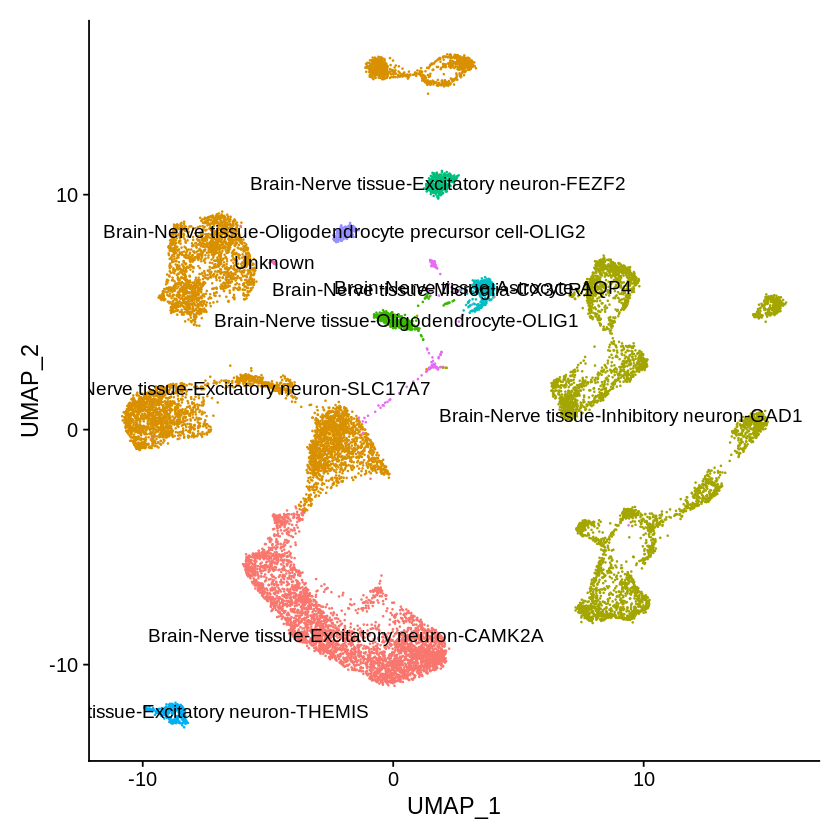

In [29]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [21]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [ ]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))